In [33]:
import csv
import typing as tp
import re
from collections import defaultdict

import numpy as np
import keras
import keras.layers
import keras.optimizers
import keras.callbacks

from tqdm import tqdm
from matplotlib import pyplot as plt
from keras.utils import pad_sequences, to_categorical
from keras.preprocessing.text import Tokenizer

import pickle

In [2]:
TO_EXCLUDE = '!"#$%&()*+-/:;<=>@[\\]^_`{|}~.,:;!?\t'
TO_TOKENIZE = '\n'

In [38]:
def load_data(file, include: str, exclude: str, size: int = None):
    _text =  []
    with open(file) as f:
        data = csv.reader(f)
        for verse, *_ in tqdm(list(data)[:size] if size is not None else list(data)):
            # Separate characters that we want to tokenize
            correct_verse = re.sub(r'(['+include+'])', r' \1 ', verse)
            # Exclude characters that we do not want to tokenize
            correct_verse = correct_verse.translate(str.maketrans('', '', exclude))
            _text.append(correct_verse.lower() + ' \n')
    return _text

TEXT = load_data('data/poems/limericks.csv', TO_TOKENIZE, TO_EXCLUDE, 1000)
print(*TEXT[:3])

100%|██████████| 1000/1000 [00:00<00:00, 66670.44it/s]

cap'n jack was washed over the side 
 his crew searched but found not hair nor hide 
 no longer the helm 
 but the deep benthic realm 
 is where jack will forever reside 
  ablactation to wean off the breast 
 should wait 'til age 2 this is best 
 though some men never quit 
 bet you thought i'd rhyme tit 
 because they're mammarially obsessed 
  as a soup bisque is best when served hot 
 made with lobster it hits the right spot 
 i think it tastes dreamy 
 it's so rich and creamy 
 it's the soup you'd be served on a yacht 
 


In [39]:
TOKENIZER = Tokenizer(filters=TO_EXCLUDE)
TOKENIZER.fit_on_texts(TEXT)
TOTAL_WORDS = len(TOKENIZER.word_index) + 1
print(TOTAL_WORDS)

7609


In [40]:
def create_sequences(text, tokenizer):
    sequences = list()
    for verse in tqdm(text):
        # for line in verse.strip().split('\n'):
        encoded = tokenizer.texts_to_sequences([verse])[0]
        for i in range(1, len(encoded)):
            sequence = encoded[:i+1]
            sequences.append(sequence)
    return sequences

SEQUENCES = create_sequences(TEXT, TOKENIZER)
print(f"Total Sequences: {len(SEQUENCES)}")

100%|██████████| 1000/1000 [00:00<00:00, 22331.51it/s]

Total Sequences: 33262


In [41]:
SEQUENCE_LENGTH = max([len(seq) for seq in SEQUENCES])
ENCODED_SEQUENCES = pad_sequences(SEQUENCES, maxlen=SEQUENCE_LENGTH, padding='pre')
X, y = ENCODED_SEQUENCES[:,:-1], to_categorical(ENCODED_SEQUENCES[:,-1], num_classes=TOTAL_WORDS)
print(f'Max Sequence Length: {SEQUENCE_LENGTH}')

Max Sequence Length: 43


In [42]:
def create_model(total_words: int, sequence_length: int):
    # define model
    model = keras.models.Sequential()
    model.add(keras.layers.Embedding(total_words, 16, input_length=sequence_length - 1))
    model.add(keras.layers.LSTM(128, return_sequences=True, activation='relu'))
    model.add(keras.layers.LSTM(64, activation='relu'))
    model.add(keras.layers.Dense(total_words, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

MODEL_NAME = "LSTMModel2"
MODEL_PATH = f"data/models/{MODEL_NAME}/weights.h5"
# MODEL = keras.models.load_model(MODEL_PATH)
MODEL = create_model(TOTAL_WORDS, SEQUENCE_LENGTH)
print(MODEL.summary())

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 42, 16)            121744    
                                                                 
 lstm_6 (LSTM)               (None, 42, 128)           74240     
                                                                 
 lstm_7 (LSTM)               (None, 64)                49408     
                                                                 
 dense_3 (Dense)             (None, 7609)              494585    
                                                                 
Total params: 739,977
Trainable params: 739,977
Non-trainable params: 0
_________________________________________________________________
None


In [29]:
REVERSE_TOKEN_INDEX = {v: k for k, v in TOKENIZER.word_index.items()}

def generate_seq(model: keras.Model, tokenizer: Tokenizer, sequence_length: int, in_text: str, max_words: int = 60):
    for _ in range(max_words):
        encoded = tokenizer.texts_to_sequences([in_text])[0]
        encoded = pad_sequences([encoded], maxlen=sequence_length - 1, padding='pre')
        predicted = np.argmax(model.predict(encoded, verbose=0))
        out_word = REVERSE_TOKEN_INDEX.get(predicted, None)
        in_text += ' ' + out_word
        if in_text.endswith('\n \n'):
            break
    return in_text


In [18]:
def create_callbacks():
    callbacks = []

    class PredictionCallback(keras.callbacks.Callback):
        def on_epoch_end(self, epoch, logs=None):
            frequency = 5
            if epoch % frequency == 0:
                seq = generate_seq(MODEL, TOKENIZER, SEQUENCE_LENGTH, "As a soup", 20)
                print(f"\n{seq}")

    callbacks.append(PredictionCallback())
    callbacks.append(keras.callbacks.EarlyStopping(monitor="loss", patience=3))
    callbacks.append(keras.callbacks.ModelCheckpoint(
        filepath=f"data/models/{MODEL_NAME}/checkpoint",
        save_weights_only=True,
        save_freq=5
    ))
    return callbacks


In [19]:
HISTORY = MODEL.fit(
    X,
    y,
    epochs=100,
    verbose=1,
    batch_size=128,
    shuffle=True,
    callbacks=create_callbacks()
)

MODEL.save(MODEL_PATH)

Epoch 1/100
268/268 [==============================] - ETA: 0s - loss: 7.6795 - accuracy: 0.1413
As a soup 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 

268/268 [==============================] - 138s 507ms/step - loss: 7.6795 - accuracy: 0.1413
Epoch 2/100
268/268 [==============================] - 132s 494ms/step - loss: 6.4369 - accuracy: 0.1751
Epoch 3/100
268/268 [==============================] - 132s 494ms/step - loss: 6.3970 - accuracy: 0.1751
Epoch 4/100
268/268 [==============================] - 133s 495ms/step - loss: 6.3772 - accuracy: 0.1751
Epoch 5/100
268/268 [==============================] - 135s 504ms/step - loss: 6.3659 - accuracy: 0.1751
Epoch 6/100
268/268 [==============================] - ETA: 0s - loss: 6.3606 - accuracy: 0.1751
As a soup 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 

268/268 [==============================] - 134s 502ms/step - loss: 6.3606 - accuracy: 0.1751
Epoch 7/100
268/268 [==============================] - 133s 495ms/step - loss: 6.3456 - accuracy: 0.

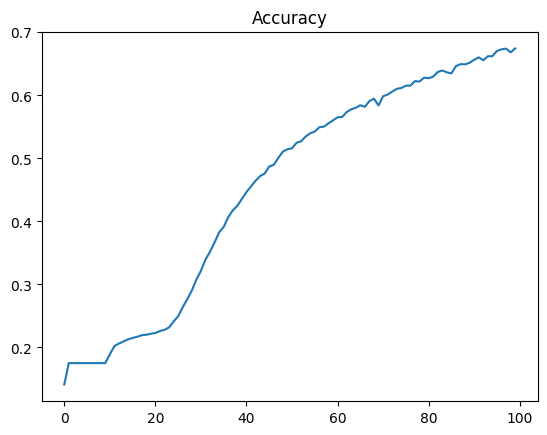

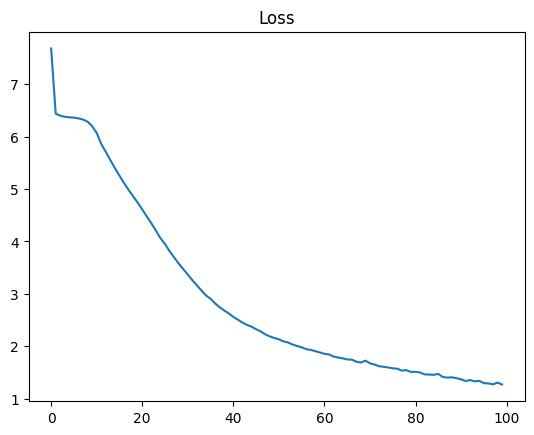

In [20]:
plt.plot(HISTORY.history['accuracy'], label="accuracy")
plt.title('Accuracy')
plt.show()

plt.plot(HISTORY.history['loss'], label="loss")
plt.title('Loss')
plt.show()

In [37]:
print(generate_seq(MODEL, TOKENIZER, SEQUENCE_LENGTH, "Oh"))

Oh a face what a name 
 every great faces faces drastic 
 earthy answer then 
 listen up at three incidental 
 



In [34]:
with open(f"data/models/{MODEL_NAME}/tokenizer.pickle", 'wb') as handle:
    pickle.dump(TOKENIZER, handle, protocol=pickle.HIGHEST_PROTOCOL)